In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

import keras
from keras import models, layers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

# This function is show max value briefly
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [2]:
images = glob.glob('../input/the-car-connection-picture-dataset/*.jpg')

data = pd.DataFrame(images, columns=['src'])

data['brand'] = data['src'].apply(lambda x : x.split('_')[0].split('/')[-1])

data['brand'].value_counts().head(3)

Chevrolet    5079
Toyota       4598
Ford         4416
Name: brand, dtype: int64

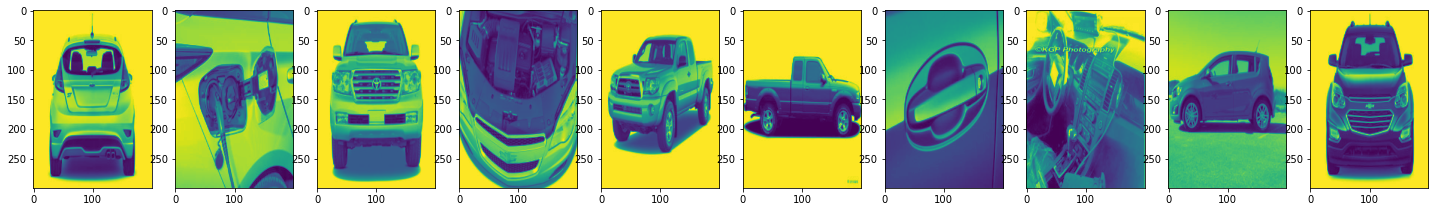

In [3]:
data = data[(data['brand']=='Chevrolet') |(data['brand']=='Toyota')|(data['brand']=='Ford')].reset_index(drop=True)
X= []
y= []
for i in range(len(data)):
    src = data.loc[i,'src']
    src = cv2.imread(src, cv2.IMREAD_COLOR)
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    X.append(cv2.resize(dst, dsize=(200, 300), interpolation=cv2.INTER_AREA))
    y.append(data.loc[i,'brand'])
    
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(X[i])

In [4]:
y[:10]

['Ford',
 'Toyota',
 'Toyota',
 'Chevrolet',
 'Toyota',
 'Ford',
 'Toyota',
 'Ford',
 'Chevrolet',
 'Chevrolet']

In [5]:
X = np.array(X)
X = X.astype('float32')
X = X /255.0
X = X.reshape(-1,300,200,1)
y= np.array(pd.get_dummies(pd.DataFrame(y),columns=[0]))

X.shape, y.shape

((14093, 300, 200, 1), (14093, 3))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9865, 300, 200, 1), (4228, 300, 200, 1), (9865, 3), (4228, 3))

In [7]:
input_shape = X_train.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation = "softmax"))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = 256, epochs = 12, shuffle=True, validation_data=(X_test,y_test),verbose = 0)


In [8]:
model.evaluate(X_test, y_test)

133/133 [==============================] - 4s 25ms/step - loss: 1.3575 - accuracy: 0.7668


[1.3574720621109009, 0.7667928338050842]

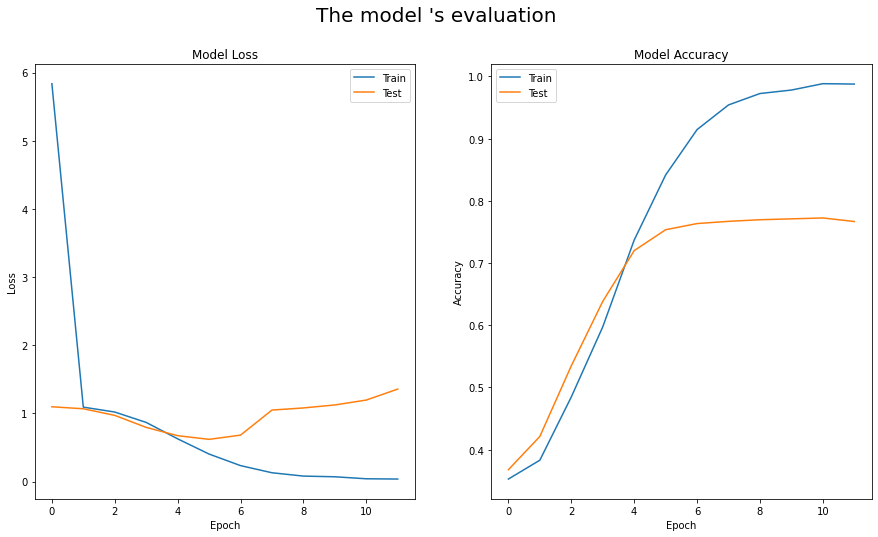

In [9]:
fig,axes = plt.subplots(1,2, figsize=(15,8))
fig.suptitle("The model 's evaluation ",fontsize=20)
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train','Test'])


axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train','Test'])
plt.show()

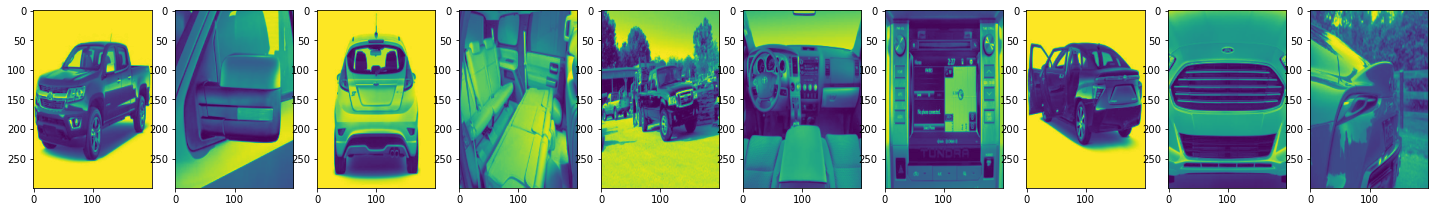

In [10]:
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(X_test[i])

In [11]:
pred = model.predict(X_test[:10])
pred = pd.DataFrame(pred).T.style.apply(highlight_max)
pred

,0,1,2,3,4,5,6,7,8,9
0,0.999891,0.000024,0.000000,0.000000,0.079831,0.000000,0.000000,0.000000,0.988241,0.762159
1,0.000003,0.999976,1.000000,0.000000,0.920167,0.000000,0.000496,0.000000,0.008538,0.235578
2,0.000106,0.000000,0.000000,1.000000,0.000002,1.000000,0.999504,1.000000,0.003220,0.002263


In [12]:
pred =model.predict(X_test[:10])


In [13]:
labels = ["Chevrolet",'Toyota','Ford']
for i in range(len(pred)):
    label = labels[np.argmax(pred[i], axis = -1)]
    print(label)

Chevrolet
Toyota
Toyota
Ford
Toyota
Ford
Ford
Ford
Chevrolet
Chevrolet


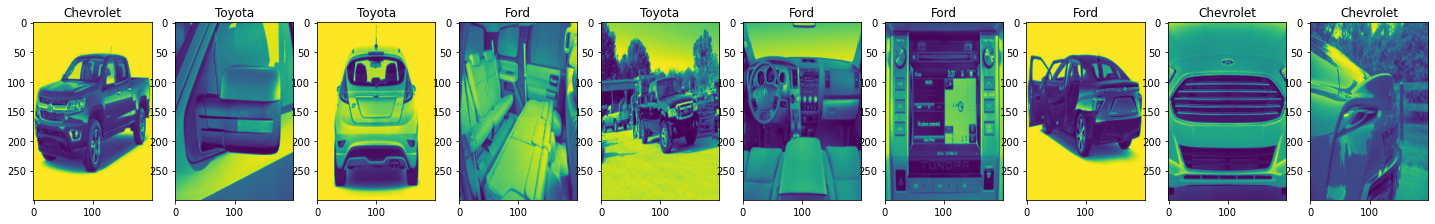

In [14]:
fig, axes = plt.subplots(1,10,figsize=(25,10))
for i in range(0,10):
    axes[i].imshow(X_test[i])
    axes[i].set_title (labels[np.argmax(pred[i], axis = -1)])

In [15]:
Real = pd.DataFrame(y_test[:10]).T

Real['brand'] =["Chevrolet",'Toyota','Ford']

Real.set_index('brand').style.apply(highlight_max)

,0,1,2,3,4,5,6,7,8,9
brand,,,,,,,,,,
Chevrolet,1,0,0,0,0,0,0,0,0,0
Toyota,0,1,1,0,1,0,0,0,1,0
Ford,0,0,0,1,0,1,1,1,0,1
